# ICEES Asthma, PM2.5 Exposure, and Drug Efficacy

In [1]:
import requests
import json
requests.packages.urllib3.disable_warnings()

In [2]:
tabular_headers = {"Content-Type" : "application/json", "accept": "text/tabular"}
json_headers = {"Content-Type" : "application/json", "accept": "application/json"}

## COHORT:44 (N = 1601) from feature variable AvgDailyPM2.5Exposure < 3

In [3]:
cohort_44_definition = '{"AvgDailyPM2.5Exposure": { "value": 3, "operator": "<" }}'
cohort_44_response = requests.post('https://icees.renci.org/1.0.0/patient/2010/cohort', data=cohort_44_definition, headers = json_headers, verify = False)
cohort_44_json = cohort_44_response.json()
print(cohort_44_json['return value'])

{'size': 1601, 'cohort_id': 'COHORT:44'}


## COHORT:54 (N = 3408) from feature variable AvgDailyPM2.5Exposure > 3

In [4]:
cohort_54_definition = '{"AvgDailyPM2.5Exposure": { "value": 3, "operator": ">" }}'
cohort_54_response = requests.post('https://icees.renci.org/1.0.0/patient/2010/cohort', data=cohort_54_definition, headers = json_headers, verify = False)
cohort_54_json = cohort_54_response.json()
print(cohort_54_json['return value'])

{'size': 3408, 'cohort_id': 'COHORT:54'}


## TotalEDInpatientVisits < 2, /associations_to_all_features endpoint, cohort 44

In [5]:
all_features_call = '{"feature":{"TotalEDInpatientVisits":{"operator":"<", "value":2}},"maximum_p_value":0.1}'
data_for_all_cohorts = {}
cohort_44_response = requests.post('https://icees.renci.org/1.0.0/patient/2010/cohort/COHORT%3A44/associations_to_all_features', headers = json_headers, data=all_features_call, verify = False)
cohort_44_response_json = cohort_44_response.json()
cohort_44_common_medication_data = []

In [6]:
cohort_44_return_value = cohort_44_response_json['return value']
for section in cohort_44_return_value:
    feature_name = section['feature_b']['feature_name']
    cohort_44_common_medication_data.append(section)
    print(section)
data_for_all_cohorts['COHORT:44 (PM2.5 Exposure < 3)']=cohort_44_common_medication_data

## TotalEDInpatientVisits < 2, /associations_to_all_features endpoint, cohort 54

In [7]:
cohort_54_response = requests.post('https://icees.renci.org/1.0.0/patient/2010/cohort/COHORT%3A54/associations_to_all_features', headers = json_headers, data=all_features_call, verify = False)
cohort_54_response_json = cohort_54_response.json()
cohort_54_common_medication_data = []

In [15]:
cohort_54_return_value = cohort_54_response_json['return value']
for section in cohort_54_return_value:
    feature_name = section['feature_b']['feature_name']
    cohort_54_common_medication_data.append(section)
    print(section)
    print()
data_for_all_cohorts['COHORT:54 (PM2.5 Exposure > 3)']=cohort_54_common_medication_data

{'total': 3408, 'p_value': 4.2841204023804765e-41, 'chi_squared': 220.38935460733464, 'feature_b': {'feature_qualifiers': [{'operator': '=', 'value': '0-2'}, {'operator': '=', 'value': '3-17'}, {'operator': '=', 'value': '18-34'}, {'operator': '=', 'value': '35-50'}, {'operator': '=', 'value': '51-69'}, {'operator': '=', 'value': '70+'}], 'feature_name': 'AgeStudyStart'}, 'feature_matrix': [[{'row_percentage': 0.9452054794520548, 'total_percentage': 0.08098591549295775, 'frequency': 276, 'column_percentage': 0.1029082774049217}, {'row_percentage': 0.0547945205479452, 'total_percentage': 0.004694835680751174, 'frequency': 16, 'column_percentage': 0.02203856749311295}], [{'row_percentage': 0.9538461538461539, 'total_percentage': 0.14553990610328638, 'frequency': 496, 'column_percentage': 0.1849366144668158}, {'row_percentage': 0.046153846153846156, 'total_percentage': 0.007042253521126761, 'frequency': 24, 'column_percentage': 0.03305785123966942}], [{'row_percentage': 0.6534653465346535

## With the 'associations_to_all_features' data in hand for cohorts 44 and 54, a dictionary containing quantities calculated from these cohorts is produced.

In [9]:
from collections import defaultdict
all_cohorts_dict = defaultdict(dict)
not_drugs = ['AgeStudyStart', 'CoughDx', 'PneumoniaDx','AvgDailyOzoneExposure','ObesityICD','AsthmaDx', 'EstProbabilityHighSchoolMaxEducation']

for cohort_id, cohort_content in data_for_all_cohorts.items():
    cohort_dict = defaultdict(dict)
    number_patients_in_cohort = cohort_content[0]['total']
    patients_with_ED_under_2_total_cohort = cohort_content[0]['columns'][0]['frequency']
    patients_with_ED_over_2_total_cohort = cohort_content[0]['columns'][1]['frequency']
    percentage_patients_with_ED_under_2_total_cohort = 100*patients_with_ED_under_2_total_cohort/number_patients_in_cohort
    for drug in cohort_content:
        drug_name = drug['feature_b']['feature_name']
        if drug_name not in not_drugs:
            drug_dict = defaultdict(dict)
            number_patients_this_drug_EDVisits_under_2 = drug['feature_matrix'][1][0]['frequency']
            number_patients_this_drug_EDVisits_over_2 = drug['feature_matrix'][1][1]['frequency']
            number_patients_admin_this_drug = drug['rows'][1]['frequency']
            number_patients_other_drugs_EDVisits_less_than_2 = drug['feature_matrix'][0][0]['frequency']
            number_patients_other_drugs_EDVisits_over_2 = drug['feature_matrix'][0][1]['frequency']
            number_patients_admin_other_drugs = drug['rows'][0]['frequency']
            Prob_A_given_B = 100*number_patients_this_drug_EDVisits_under_2/number_patients_admin_this_drug
            drug_dict['For all patients taking Drug, the percentage with EDVisits<2'] = Prob_A_given_B
            Prob_B_given_A = 100*(number_patients_this_drug_EDVisits_under_2/patients_with_ED_under_2_total_cohort)
            drug_dict['For all patients with EDVisits<2, the percentage taking Drug'] = Prob_B_given_A
            drug_dict['Responsiveness to Treatment given Administration of this Drug'] = round(Prob_A_given_B - percentage_patients_with_ED_under_2_total_cohort, 2)
            cohort_dict[drug_name] = dict(drug_dict)
    all_cohorts_dict[cohort_id]=dict(cohort_dict)

In [10]:
import pandas

all_cohorts_dict_reformatted = {(outerKey, innerKey): values for outerKey, innerDict in all_cohorts_dict.items() for innerKey, values in innerDict.items()}
all_cohorts_dict_table = pandas.DataFrame(all_cohorts_dict_reformatted)
all_cohorts_dict_table.round(2)

COHORT:44 (PM2.5 Exposure < 3)  \
                                                                       Prednisone   
For all patients taking Drug, the percentage wi...                          84.46   
For all patients with EDVisits<2, the percentag...                          11.06   
Responsiveness to Treatment given Administratio...                          -7.61   

                                                                    \
                                                   Diphenhydramine   
For all patients taking Drug, the percentage wi...           84.43   
For all patients with EDVisits<2, the percentag...           13.98   
Responsiveness to Treatment given Administratio...           -7.64   

                                                   COHORT:54 (PM2.5 Exposure > 3)  \
                                                                       Prednisone   
For all patients taking Drug, the percentage wi...                          70.24   
For all patients with EDVisits<2, the percentag...                           9.77   
Responsiveness to Treatment given Administratio...                          -8.46   

                                                                    \
                                                   Diphenhydramine   
For all patients taking Drug, the percentage wi...           66.67   
For all patients with EDVisits<2, the percentag...           11.26   
Responsiveness to Treatment given Administratio...          -12.03   

                                                                           
                                                   Ipratropium Salmeterol  
For all patients taking Drug, the percentage wi...       61.40      33.33  
For all patients with EDVisits<2, the percentag...        4.92       0.11  
Responsiveness to Treatment given Administratio...      -17.30     -45.36

In [16]:
#import matplotlib.pyplot as plt

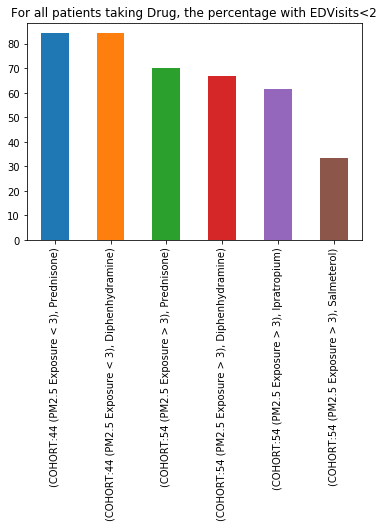

In [17]:
plot0 = all_cohorts_dict_table.iloc[0].plot(kind='bar',title = 'For all patients taking Drug, the percentage with EDVisits<2')


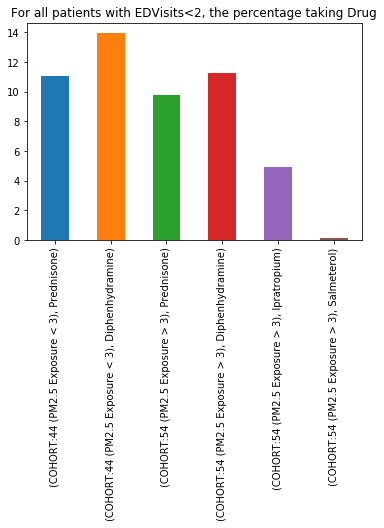

In [13]:
all_cohorts_dict_table.iloc[1].plot(kind='bar', title = 'For all patients with EDVisits<2, the percentage taking Drug')

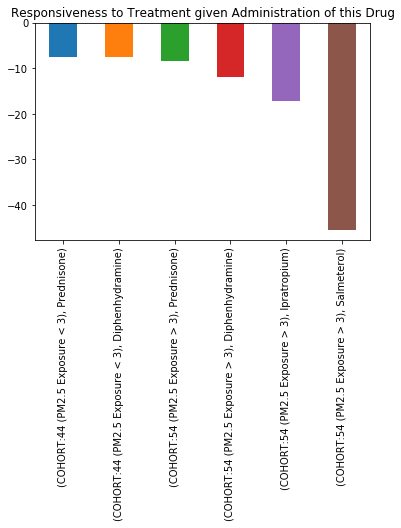

In [14]:
all_cohorts_dict_table.iloc[2].plot(kind='bar', title='Responsiveness to Treatment given Administration of this Drug')

tap into Ros output
tap into CMAQ API